In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

operating_system = 'mac'

if operating_system == 'win':
    os.chdir('C:/Users/fabau/OneDrive/Documents/GitHub/master-project-cleaned/')
elif operating_system == 'curnagl':
    os.chdir('/work/FAC/FGSE/IDYST/tbeucler/default/fabien/repos/cleaner_version/')
else:
    os.chdir('/Users/fabienaugsburger/Documents/GitHub/master-project-cleaned/')

util_perso = os.path.abspath('util/processing')
sys.path.append(util_perso)

import extraction_squares

### test for the custom function

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error
#from sklearn.linear_model import Ridge  # Example model
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor


def find_best_meteorological_variables(X_vars, Y, folds=5, model_type=RandomForestRegressor, model_params=None):
    """
    Find the best combination of meteorological variables to predict the target.

    Args:
        X_vars (list of numpy.ndarray): List of input arrays for each variable, shape (n_i, m).
        Y (numpy.ndarray): Output data, shape (m, 15).
        folds (int): Number of folds for cross-validation.
        model_type: The model class to use.
        model_params (dict): Parameters for initializing the model.

    Returns:
        dict: Dictionary with the best combination of variables and the corresponding RMSE.
    """
    n_vars = len(X_vars)
    best_rmse = float('inf')
    best_combination = None
    rmse_scores_per_combination = []

    for num_vars in range(1, n_vars + 1):  # Add variables one at a time
        combined_X = np.concatenate(X_vars[:num_vars], axis=0)  # Combine first `num_vars` variables
        print(f"Testing with {num_vars} variables...")

        kf = KFold(n_splits=folds, shuffle=True, random_state=42)
        rmse_scores = []

        for train_index, val_index in kf.split(combined_X.T):  # Transpose X for (m, features)
            X_train, X_val = combined_X[:, train_index], combined_X[:, val_index]
            Y_train, Y_val = Y[train_index], Y[val_index]

            model = model_type(**(model_params or {}))
            model.fit(X_train.T, Y_train)  # Transpose back to (m_train, features)
            Y_pred = model.predict(X_val.T)

            rmse = root_mean_squared_error(Y_val, Y_pred)
            rmse_scores.append(rmse)

        avg_rmse = np.mean(rmse_scores)
        rmse_scores_per_combination.append(avg_rmse)
        print(f"Average RMSE with {num_vars} variables: {np.round(avg_rmse,4)}")

        if avg_rmse < best_rmse:
            best_rmse = avg_rmse
            best_combination = list(range(1, num_vars + 1))

    print(f"Best combination: Variables {best_combination} with RMSE {np.round(best_rmse, 4)}")
    return {"best_combination": best_combination, "best_rmse": np.round(best_rmse,4), "all_rmse": rmse_scores_per_combination}


# Example usage
n1, n2, n3, m = 10, 8, 12, 100  # Example dimensions for 3 variables
X1 = np.random.random((n1, m))  # Variable 1
X2 = np.random.random((n2, m))  # Variable 2
X3 = np.random.random((n3, m))  # Variable 3
Y = np.random.random((m, 15))   # Output data

result = find_best_meteorological_variables(
    [X1, X2, X3], Y, folds=5, model_type=RandomForestRegressor, model_params=None
)

Testing with 1 variables...
Average RMSE with 1 variables: 0.2995
Testing with 2 variables...
Average RMSE with 2 variables: 0.2979
Testing with 3 variables...
Average RMSE with 3 variables: 0.2962
Best combination: Variables [1, 2, 3] with RMSE 0.2962


In [7]:
all_loadings = pd.read_csv('data/PCA/PCA_loadings_98/all_loadings.csv')
u_gust = pd.read_csv('data/climatology_dm_winter_per_cluster/EVENT_max/max_event_dm_combined.csv')

u_gust = u_gust.drop(columns=['storm_name'])
z_gust = pd.read_csv('data/climatology_dm_winter_per_cluster/GEV_CDF_max/log_cdf_max_dm_combined.csv').drop(columns=['storm_name'])

variables = pd.read_csv('data/variable_list_levels_stats.csv')
variables = pd.Series(variables['variables'])

all_input = []
all_var_names = []

# group the loadings per meteorological variable
for var in variables.values:
    print(var)
    try:
        temp = pd.read_csv(f'data/PCA/PCA_loadings_98/{var}.csv')
    except:
        print(f'No file for {var}')
        continue
    #temp = temp.drop(columns=['Unnamed: 0'])
    temp = temp.drop(columns=['variable'])
    storm_index = pd.DataFrame([temp.columns],  columns=temp.columns)
    temp = pd.concat([storm_index, temp], ignore_index=True)
    #result = find_best_meteorological_variables(
    #    temp, Y, folds=5, model_type=RandomForestRegressor, model_params={'n_jobs':-1}
    #    )
    all_input.append(temp.values)
    all_var_names.append(var)


10m_magnitude_of_wind_max
10m_magnitude_of_wind_min
10m_magnitude_of_wind_mean
10m_magnitude_of_wind_std
100m_magnitude_of_wind_max
100m_magnitude_of_wind_min
100m_magnitude_of_wind_mean
100m_magnitude_of_wind_std
10m_orientation_of_wind_max
10m_orientation_of_wind_min
10m_orientation_of_wind_mean
10m_orientation_of_wind_std
100m_orientation_of_wind_max
100m_orientation_of_wind_min
100m_orientation_of_wind_mean
100m_orientation_of_wind_std
2m_dewpoint_temperature_max
2m_dewpoint_temperature_min
2m_dewpoint_temperature_mean
2m_dewpoint_temperature_std
2m_temperature_max
2m_temperature_min
2m_temperature_mean
2m_temperature_std
convective_available_potential_energy_max
convective_available_potential_energy_min
convective_available_potential_energy_mean
convective_available_potential_energy_std
convective_precipitation_max
No file for convective_precipitation_max
convective_precipitation_min
No file for convective_precipitation_min
convective_precipitation_mean
No file for convective_prec

In [8]:
result = find_best_meteorological_variables(
    all_input, Y, folds=5, model_type=RandomForestRegressor, model_params={'n_jobs':-1}
)

Testing with 1 variables...
Average RMSE with 1 variables: 0.2929
Testing with 2 variables...
Average RMSE with 2 variables: 0.2876
Testing with 3 variables...
Average RMSE with 3 variables: 0.2862
Testing with 4 variables...
Average RMSE with 4 variables: 0.288
Testing with 5 variables...
Average RMSE with 5 variables: 0.2867
Testing with 6 variables...
Average RMSE with 6 variables: 0.2855
Testing with 7 variables...
Average RMSE with 7 variables: 0.2873
Testing with 8 variables...
Average RMSE with 8 variables: 0.2871
Testing with 9 variables...
Average RMSE with 9 variables: 0.2868
Testing with 10 variables...
Average RMSE with 10 variables: 0.287
Testing with 11 variables...
Average RMSE with 11 variables: 0.285
Testing with 12 variables...
Average RMSE with 12 variables: 0.2893
Testing with 13 variables...
Average RMSE with 13 variables: 0.2875
Testing with 14 variables...
Average RMSE with 14 variables: 0.2865
Testing with 15 variables...
Average RMSE with 15 variables: 0.2873
T

KeyboardInterrupt: 

Testing with 1 variables...
To keep 50 storms in the training set, storms 45 and 87 are removed from the test set.
Average RMSE with 1 variables: 6.0057
Testing with 2 variables...
To keep 50 storms in the training set, storms 45 and 87 are removed from the test set.
Average RMSE with 2 variables: 5.9677
Testing with 3 variables...
To keep 50 storms in the training set, storms 45 and 87 are removed from the test set.
Average RMSE with 3 variables: 5.9889
Testing with 4 variables...
To keep 50 storms in the training set, storms 45 and 87 are removed from the test set.
Average RMSE with 4 variables: 5.977
Testing with 5 variables...
To keep 50 storms in the training set, storms 45 and 87 are removed from the test set.
Average RMSE with 5 variables: 5.9742
Testing with 6 variables...
To keep 50 storms in the training set, storms 45 and 87 are removed from the test set.
Average RMSE with 6 variables: 5.9084
Testing with 7 variables...
To keep 50 storms in the training set, storms 45 and 87

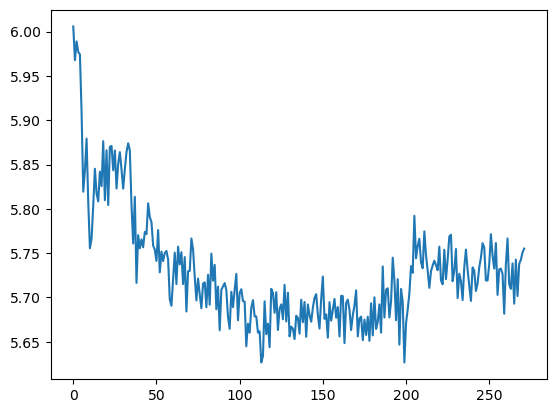

Best combination: Variables [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200] with RMSE 5.6267
{'best_combination': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1

In [17]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor  # Example model
from xgboost import XGBRegressor  # Alternate model
# explicitly require this experimental feature
from sklearn.experimental import enable_halving_search_cv # noqa
# now you can import normally from model_selection
from sklearn.model_selection import HalvingGridSearchCV


#def find_best_meteorological_variables(X_vars, Y, folds=5, model_type=RandomForestRegressor, model_params=None):
"""
Find the best combination of meteorological variables to predict the target.

Args:
    X_vars (list of numpy.ndarray): List of input arrays for each variable, shape (n_i, m).
    Y (numpy.ndarray): Output data, shape (m, 15).
    folds (int): Number of folds for cross-validation.
    model_type: The model class to use.
    model_params (dict): Parameters for initializing the model.

Returns:
    dict: Dictionary with the best combination of variables and the corresponding RMSE.
"""
X_vars = all_input
Y = u_gust
folds = 7
model_type = RandomForestRegressor
model_params = {}#{'n_jobs':-1}

n_vars = len(X_vars)
best_rmse = float('inf')
best_combination = None
rmse_scores_per_combination = []

for num_vars in range(1, n_vars + 1):  # Add variables one at a time

    combined_X = np.concatenate(X_vars[:num_vars], axis=0)  # Combine first `num_vars` variables
    print(f"Testing with {num_vars} variables...")

    kf = KFold(n_splits=folds, shuffle=True, random_state=42)
    rmse_scores = []

    storm_index = combined_X[0, :].astype(int)

    # Remove test storms

    _, test_storms, _ = extraction_squares.split_storm_numbers(storm_index, 0.12, 'number', 42)
    storm_index = storm_index[~np.isin(storm_index, test_storms)]

    for train_index, val_index in kf.split(storm_index):  # Transpose X for (m, features)
        X_train, X_val = combined_X[:, train_index], combined_X[:, val_index]
        train_index, val_index = storm_index[train_index], storm_index[val_index]
        Y_train, Y_val = Y[Y['storm_number'].isin(train_index)], Y[Y['storm_number'].isin(val_index)]

        # drop the storm_number column
        Y_train = Y_train.drop(columns=['storm_number'])
        Y_val = Y_val.drop(columns=['storm_number'])
        # drop the first row of X_train and X_val
        X_train = X_train[1:, :]
        X_val = X_val[1:, :]

        model = model_type(random_state = 42, n_jobs = -1)#**(model_params or {}))
        model.fit(X_train.T, Y_train)  # Transpose back to (m_train, features)
        Y_pred = model.predict(X_val.T)

        # RMSE Calculation
        rmse_bef = root_mean_squared_error(Y_val, Y_pred)

        # # Hypertuning
        # if model_type == RandomForestRegressor:
        #     param_grid_mod = {
        #         'n_estimators': [5, 10, 20, 50, 100, 200, 500],
        #         'max_depth': [1, 2, 3, 5, 10, 20, 40]
        #     }
        # else:
        #     param_grid_mod = model_params

        # search = HalvingGridSearchCV(model, param_grid_mod, cv=2, n_jobs=-1, verbose=0)
        # search.fit(X_train.T, Y_train)

        # # Get best model after tuning
        # best_model = search.best_estimator_
        # Y_pred = best_model.predict(X_val.T)

        # rmse_aft = root_mean_squared_error(Y_val, Y_pred)

        # if rmse_aft < rmse_bef:
        #     rmse_scores.append(rmse_aft)
        # else:
        rmse_scores.append(rmse_bef)

    avg_rmse = np.mean(rmse_scores)
    rmse_scores_per_combination.append(avg_rmse)
    print(f"Average RMSE with {num_vars} variables: {np.round(avg_rmse, 4)}")

    if avg_rmse < best_rmse:
        best_rmse = avg_rmse
        best_combination = list(range(1, num_vars + 1))

plt.plot(rmse_scores_per_combination)
plt.show()

print(f"Best combination: Variables {best_combination} with RMSE {np.round(best_rmse, 4)}")
print( {
    "best_combination": best_combination,
    "best_rmse": np.round(best_rmse, 4),
    "all_rmse": rmse_scores_per_combination,
})

### Don't use it, it'll take 9 years to complete it (checks every pc loadings with every pc loadings)

In [31]:
import numpy as np
import pandas as pd
from itertools import combinations
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

def find_best_features(inputs, targets, model_type='xgboost', x_folds=5, early_stop_rounds=5):
    """
    Test all feature combinations to find the lowest RMSE using XGBoost or Random Forest.
    
    Parameters:
    - inputs (pd.DataFrame): Feature dataframe with storm numbers as column names (excluding first column for predictor names).
    - targets (pd.DataFrame): Target dataframe with the first column ('storm_index') as the storm number.
    - model_type (str): 'xgboost' or 'random_forest'.
    - x_folds (int): Number of cross-validation folds.
    - early_stop_rounds (int): Stop after RMSE doesn't improve for this many iterations.

    Returns:
    - best_rmse (float): Lowest RMSE achieved.
    - best_features (list): Subset of features achieving the lowest RMSE.
    """
    # Ensure storm numbers are strings for alignment
    inputs.columns = inputs.columns.astype(str)
    targets['storm_index'] = targets['storm_number'].astype(str)
    
    # Extract storm numbers and align inputs and targets
    storm_numbers = inputs.columns[1:]  # Exclude first column (variable names)
    input_matrix = inputs.iloc[:, 1:].to_numpy()  # Exclude first column for feature matrix
    target_matrix = targets.set_index('storm_index').loc[storm_numbers].to_numpy()  # Align by storm number

    n_features = input_matrix.shape[0]
    best_rmse = float('inf')
    best_features = []
    no_improve_count = 0

    # Generate all combinations of features
    for i in range(1, n_features + 1):  # Start with 1 feature up to all features
        for feature_comb in combinations(range(n_features), i):  # Test all combinations of size i
            fold_rmses = []

            kf = KFold(n_splits=x_folds, shuffle=True, random_state=42)
            for train_idx, val_idx in kf.split(range(input_matrix.shape[1])):
                # Subset data for current fold
                X_train, X_val = input_matrix[list(feature_comb), :][:, train_idx], input_matrix[list(feature_comb), :][:, val_idx]
                y_train, y_val = target_matrix[train_idx], target_matrix[val_idx]
                
                if model_type == 'xgboost':
                    model = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)
                elif model_type == 'random_forest':
                    model = RandomForestRegressor(random_state=42, n_jobs=-1)
                else:
                    raise ValueError("Invalid model_type. Use 'xgboost' or 'random_forest'.")
                
                # Train the model
                model.fit(X_train.T, y_train)
                
                # Predict and calculate RMSE
                predictions = model.predict(X_val.T)
                fold_rmse = np.sqrt(mean_squared_error(y_val, predictions))
                fold_rmses.append(fold_rmse)
            
            # Average RMSE across folds
            mean_rmse = np.mean(fold_rmses)
            
            if mean_rmse < best_rmse:
                best_rmse = mean_rmse
                best_features = feature_comb
                no_improve_count = 0
            else:
                no_improve_count += 1
            
            # Early stopping
            if no_improve_count >= early_stop_rounds:
                print("Stopping early due to no improvement in RMSE.")
                break
    
    # Convert best feature indices back to feature names
    best_feature_names = inputs.iloc[list(best_features), 0].tolist()  # Get names from first column
    return best_rmse, best_feature_names

In [32]:
best_rmse, best_features = find_best_features(all_loadings, u_gust, model_type='xgboost', x_folds=5, early_stop_rounds=5)
print("Best RMSE:", best_rmse)
print("Best features:", best_features)

Stopping early due to no improvement in RMSE.
Stopping early due to no improvement in RMSE.


KeyboardInterrupt: 

In [35]:
import numpy as np
import pandas as pd
from itertools import combinations
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from joblib import Parallel, delayed

def evaluate_combination(feature_comb, input_matrix, target_matrix, model_type, x_folds):
    """
    Evaluate a single feature combination.
    """
    kf = KFold(n_splits=x_folds, shuffle=True, random_state=42)
    fold_rmses = []

    for train_idx, val_idx in kf.split(range(input_matrix.shape[1])):
        X_train, X_val = input_matrix[list(feature_comb), :][:, train_idx], input_matrix[list(feature_comb), :][:, val_idx]
        y_train, y_val = target_matrix[train_idx], target_matrix[val_idx]

        if model_type == 'xgboost':
            model = XGBRegressor(objective='reg:squarederror', random_state=42)
        elif model_type == 'random_forest':
            model = RandomForestRegressor(random_state=42)
        else:
            raise ValueError("Invalid model_type. Use 'xgboost' or 'random_forest'.")

        model.fit(X_train.T, y_train)
        predictions = model.predict(X_val.T)
        fold_rmse = np.sqrt(mean_squared_error(y_val, predictions))
        fold_rmses.append(fold_rmse)

    return np.mean(fold_rmses), feature_comb

def find_best_features_parallel(inputs, targets, model_type='xgboost', x_folds=5, early_stop_rounds=5, n_jobs=-1):
    """
    Test all feature combinations in parallel to find the lowest RMSE using XGBoost or Random Forest.

    Parameters:
    - inputs (pd.DataFrame): Feature dataframe with storm numbers as column names (excluding first column for predictor names).
    - targets (pd.DataFrame): Target dataframe with the first column ('storm_index') as the storm number.
    - model_type (str): 'xgboost' or 'random_forest'.
    - x_folds (int): Number of cross-validation folds.
    - early_stop_rounds (int): Stop after RMSE doesn't improve for this many iterations.
    - n_jobs (int): Number of jobs for parallel processing (-1 uses all available cores).

    Returns:
    - best_rmse (float): Lowest RMSE achieved.
    - best_features (list): Subset of features achieving the lowest RMSE.
    """
    # Ensure storm numbers are strings for alignment
    inputs.columns = inputs.columns.astype(str)
    targets['storm_number'] = targets['storm_number'].astype(str)

    # Extract storm numbers and align inputs and targets
    storm_numbers = inputs.columns[1:]  # Exclude first column (variable names)
    input_matrix = inputs.iloc[:, 1:].to_numpy()  # Exclude first column for feature matrix
    target_matrix = targets.set_index('storm_number').loc[storm_numbers].to_numpy()  # Align by storm number

    n_features = input_matrix.shape[0]
    best_rmse = float('inf')
    best_features = []
    no_improve_count = 0

    for i in range(1, n_features + 1):  # Start with 1 feature up to all features
        feature_combinations = list(combinations(range(n_features), i))
        
        # Evaluate combinations in parallel
        results = Parallel(n_jobs=n_jobs)(
            delayed(evaluate_combination)(feature_comb, input_matrix, target_matrix, model_type, x_folds)
            for feature_comb in feature_combinations
        )

        # Process results
        for mean_rmse, feature_comb in results:
            if mean_rmse < best_rmse:
                best_rmse = mean_rmse
                best_features = feature_comb
                no_improve_count = 0
            else:
                no_improve_count += 1
            
            # Early stopping
            if no_improve_count >= early_stop_rounds:
                print("Stopping early due to no improvement in RMSE.")
                return best_rmse, inputs.iloc[list(best_features), 0].tolist()  # Return feature names

    # Convert best feature indices back to feature names
    best_feature_names = inputs.iloc[list(best_features), 0].tolist()  # Get names from first column
    return best_rmse, best_feature_names

In [36]:
best_rmse, best_features = find_best_features_parallel(all_loadings, u_gust, model_type='xgboost', x_folds=5, early_stop_rounds=5, n_jobs=-1)
print("Best RMSE:", best_rmse)
print("Best features:", best_features)

Stopping early due to no improvement in RMSE.
Best RMSE: 11.987028635072283
Best features: ['10m_magnitude_of_wind_max']


### Testing one set of environmental predictors and then add them one by one (but fixed)

In [16]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from joblib import Parallel, delayed
from collections import defaultdict

def group_features_by_predictor(feature_names):
    """
    Groups features by their base environmental predictor.
    Handles cases where variables start with 'mean' or other statistical terms.

    Example:
        Input: ['mean_surface_pressure_mean_PCA_3', 'k_index_max_PCA_1']
        Output: {'mean_surface_pressure': ['mean_surface_pressure_mean_PCA_3'],
                 'k_index': ['k_index_max_PCA_1']}
    """
    grouped_features = defaultdict(list)
    for name in feature_names:
        # Split on '_PCA_' or '_max', '_min', etc., but handle leading statistical terms correctly
        parts = name.split('_')
        for i, part in enumerate(parts):
            if part in ['max', 'min', 'mean', 'std', 'PCA'] and i > 0:
                # Take all parts before the current match as the base predictor
                base_predictor = '_'.join(parts[:i])
                grouped_features[base_predictor].append(name)
                break
    return grouped_features

def evaluate_group_combination(group_names, feature_groups, input_matrix, target_matrix, model_type, x_folds):
    """
    Evaluate a combination of groups by including all features in the groups.
    Includes climate comparison.
    """
    kf = KFold(n_splits=x_folds, shuffle=True, random_state=42)
    fold_rmses = []
    fold_rmses_climate = []

    # Get indices for features in the selected groups
    selected_features = [feature for group in group_names for feature in feature_groups[group]]
    selected_indices = [feature_names.index(name) for name in selected_features]

    for train_idx, val_idx in kf.split(range(input_matrix.shape[1])):
        X_train, X_val = input_matrix[selected_indices, :][:, train_idx], input_matrix[selected_indices, :][:, val_idx]
        y_train, y_val = target_matrix[train_idx], target_matrix[val_idx]

        if model_type == 'xgboost':
            model = XGBRegressor(objective='reg:squarederror', random_state=42)
        elif model_type == 'random_forest':
            model = RandomForestRegressor(random_state=42)
        else:
            raise ValueError("Invalid model_type. Use 'xgboost' or 'random_forest'.")

        # Train model and make predictions
        model.fit(X_train.T, y_train)
        predictions = model.predict(X_val.T)

        # Calculate climate predictions (mean of the training set)
        climate_mean = np.mean(y_train, axis=0)  # Mean across training storms for each cluster
        predictions_climate = np.tile(climate_mean, (y_val.shape[0], 1))  # Match shape of y_val

        # Compute RMSEs
        fold_rmse = np.sqrt(mean_squared_error(y_val, predictions))
        fold_rmse_climate = np.sqrt(mean_squared_error(y_val, predictions_climate))

        fold_rmses.append(fold_rmse)
        fold_rmses_climate.append(fold_rmse_climate)

    return np.mean(fold_rmses), group_names, np.mean(fold_rmses_climate), model, X_train, X_val

def incremental_group_search(inputs, targets, model_type='xgboost', x_folds=5, early_stop_rounds=5, n_jobs=-1):
    """
    Incrementally add groups of predictors to find the best combination.
    
    Parameters:
    - inputs (pd.DataFrame): Feature dataframe with storm numbers as column names (excluding first column for predictor names).
    - targets (pd.DataFrame): Target dataframe with the first column ('storm_index') as the storm number.
    - model_type (str): 'xgboost' or 'random_forest'.
    - x_folds (int): Number of cross-validation folds.
    - early_stop_rounds (int): Stop after RMSE doesn't improve for this many iterations.
    - n_jobs (int): Number of jobs for parallel processing (-1 uses all available cores).

    Returns:
    - best_rmse (float): Lowest RMSE achieved.
    - best_groups (list): Subset of groups achieving the lowest RMSE.
    """
    # Ensure storm numbers are strings for alignment
    inputs.columns = inputs.columns.astype(str)
    targets['storm_number'] = targets['storm_number'].astype(str)

    # Extract storm numbers and align inputs and targets
    storm_numbers = inputs.columns[1:]  # Exclude first column (variable names)
    input_matrix = inputs.iloc[:, 1:].to_numpy()  # Exclude first column for feature matrix
    target_matrix = targets.set_index('storm_number').loc[storm_numbers].to_numpy()  # Align by storm number

    # Extract feature names and group them
    global feature_names  # Used in evaluate_group_combination
    feature_names = inputs.iloc[:, 0].tolist()
    feature_groups = group_features_by_predictor(feature_names)

    group_names = list(feature_groups.keys())
    best_rmse = float('inf')
    best_groups = []
    no_improve_count = 0
    remaining_groups = group_names.copy()

    iteration = 1
    while remaining_groups:
        print(f"\n--- Iteration {iteration} ---")
        print(f"Current best RMSE: {best_rmse}")
        print(f"Best groups so far: {best_groups if best_groups else 'None'}")
        print(f"Remaining groups to test: {remaining_groups}")

        # Evaluate all remaining groups combined with the current best set
        results = Parallel(n_jobs=n_jobs)(
            delayed(evaluate_group_combination)(
                best_groups + [new_group], feature_groups, input_matrix, target_matrix, model_type, x_folds
            )
            for new_group in remaining_groups
        )

        # Find the best result in this iteration
        improved = False
        for mean_rmse, group_comb, mean_rmse_climate, model, X_train, X_val in results:
            print(f"Tested combination: {group_comb}, RMSE: {mean_rmse}, RMSE Climate: {mean_rmse_climate}")
            if mean_rmse < best_rmse:
                print(f"Improvement found with {group_comb}. New best RMSE: {mean_rmse}, RMSE Climate: {mean_rmse_climate}")
                best_rmse = mean_rmse
                best_groups = group_comb
                remaining_groups.remove(group_comb[-1])  # Remove the newly added group
                no_improve_count = 0
                improved = True
                best_model = model
                X_train = X_train
                X_val = X_val
                break  # Stop searching once we find an improvement

        if not improved:
            no_improve_count += 1
            print("No improvement in this iteration.")

        # Early stopping
        if no_improve_count >= early_stop_rounds:
            print("Stopping early due to no improvement in RMSE.")
            break

        iteration += 1

    print("\nSearch complete.")
    print(f"Best RMSE achieved: {best_rmse}, with RMSE Climate: {mean_rmse_climate}")
    print(f"Best group combination: {best_groups}")

    return best_rmse, best_groups, best_model, X_train, X_val

In [18]:
best_rmse, best_groups, best_model, X_train, X_val = incremental_group_search(
    all_loadings, z_gust, model_type='random_forest', x_folds=5, early_stop_rounds=3, n_jobs=-1
)
print("Best RMSE:", best_rmse)
print("Best groups:", best_groups)


--- Iteration 1 ---
Current best RMSE: inf
Best groups so far: None
Remaining groups to test: ['10m_magnitude_of_wind', '100m_magnitude_of_wind', '10m_orientation_of_wind', '100m_orientation_of_wind', '2m_dewpoint_temperature', '2m_temperature', 'convective_available_potential_energy', 'geopotential_500', 'geopotential_1000', 'high_cloud_cover', 'k_index', 'large_scale_precipitation', 'large_scale_snowfall', 'mean_large_scale_precipitation_rate', 'mean_top_net_long_wave_radiation_flux', 'mean_top_net_short_wave_radiation_flux', 'mean_total_precipitation_rate', 'mean_sea_level_pressure', 'mean_surface_latent_heat_flux', 'mean_surface_sensible_heat_flux', 'mean_surface_net_long_wave_radiation_flux', 'mean_surface_net_short_wave_radiation_flux', 'mean_vertically_integrated_moisture_divergence', 'relative_humidity_10', 'relative_humidity_20', 'relative_humidity_30', 'relative_humidity_50', 'relative_humidity_70', 'relative_humidity_100', 'relative_humidity_150', 'relative_humidity_200', '

### Tests with all group possibilities (crashes everytime)

In [3]:
from itertools import combinations
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from joblib import Parallel, delayed
from collections import defaultdict

def group_features_by_predictor(feature_names):
    """
    Groups features by their base environmental predictor.
    Handles cases where variables start with 'mean' or other statistical terms.

    Example:
        Input: ['mean_surface_pressure_mean_PCA_3', 'k_index_max_PCA_1']
        Output: {'mean_surface_pressure': ['mean_surface_pressure_mean_PCA_3'],
                 'k_index': ['k_index_max_PCA_1']}
    """
    grouped_features = defaultdict(list)
    for name in feature_names:
        # Split on '_PCA_' or '_max', '_min', etc., but handle leading statistical terms correctly
        parts = name.split('_')
        for i, part in enumerate(parts):
            if part in ['max', 'min', 'mean', 'std', 'PCA'] and i > 0:
                # Take all parts before the current match as the base predictor
                base_predictor = '_'.join(parts[:i])
                grouped_features[base_predictor].append(name)
                break
    return grouped_features

def evaluate_group_combination(group_names, feature_groups, input_matrix, target_matrix, model_type, x_folds):
    """
    Evaluate a combination of groups by including all features in the groups.
    Includes climate comparison.
    """
    kf = KFold(n_splits=x_folds, shuffle=True, random_state=42)
    fold_rmses = []
    fold_rmses_climate = []

    # Get indices for features in the selected groups
    selected_features = [feature for group in group_names for feature in feature_groups[group]]
    selected_indices = [feature_names.index(name) for name in selected_features]

    for train_idx, val_idx in kf.split(range(input_matrix.shape[1])):
        X_train, X_val = input_matrix[selected_indices, :][:, train_idx], input_matrix[selected_indices, :][:, val_idx]
        y_train, y_val = target_matrix[train_idx], target_matrix[val_idx]

        if model_type == 'xgboost':
            model = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)
        elif model_type == 'random_forest':
            model = RandomForestRegressor(random_state=42, n_jobs=-1)
        else:
            raise ValueError("Invalid model_type. Use 'xgboost' or 'random_forest'.")

        # Train model and make predictions
        model.fit(X_train.T, y_train)
        predictions = model.predict(X_val.T)

        # Calculate climate predictions (mean of the training set)
        climate_mean = np.mean(y_train, axis=0)  # Mean across training storms for each cluster
        predictions_climate = np.tile(climate_mean, (y_val.shape[0], 1))  # Match shape of y_val

        # Compute RMSEs
        fold_rmse = np.sqrt(mean_squared_error(y_val, predictions))
        fold_rmse_climate = np.sqrt(mean_squared_error(y_val, predictions_climate))

        fold_rmses.append(fold_rmse)
        fold_rmses_climate.append(fold_rmse_climate)

    return np.mean(fold_rmses), group_names, np.mean(fold_rmses_climate), model


def exhaustive_group_search(inputs, targets, model_type='xgboost', x_folds=5, n_jobs=-1):
    """
    Exhaustively test all combinations of groups of predictors to find the best combination.
    
    Parameters:
    - inputs (pd.DataFrame): Feature dataframe with storm numbers as column names (excluding first column for predictor names).
    - targets (pd.DataFrame): Target dataframe with the first column ('storm_index') as the storm number.
    - model_type (str): 'xgboost' or 'random_forest'.
    - x_folds (int): Number of cross-validation folds.
    - n_jobs (int): Number of jobs for parallel processing (-1 uses all available cores).

    Returns:
    - best_rmse (float): Lowest RMSE achieved.
    - best_groups (list): Subset of groups achieving the lowest RMSE.
    - best_rmse_climate (float): Climate baseline RMSE.
    """
    # Ensure storm numbers are strings for alignment
    inputs.columns = inputs.columns.astype(str)
    targets['storm_number'] = targets['storm_number'].astype(str)

    # Extract storm numbers and align inputs and targets
    storm_numbers = inputs.columns[1:]  # Exclude first column (variable names)
    input_matrix = inputs.iloc[:, 1:].to_numpy()  # Exclude first column for feature matrix
    target_matrix = targets.set_index('storm_number').loc[storm_numbers].to_numpy()  # Align by storm number

    # Extract feature names and group them
    global feature_names  # Used in evaluate_group_combination
    feature_names = inputs.iloc[:, 0].tolist()
    feature_groups = group_features_by_predictor(feature_names)

    group_names = list(feature_groups.keys())
    best_rmse = float('inf')
    best_rmse_climate = float('inf')
    best_groups = []

    print(f"Testing all combinations of {len(group_names)} groups...\n")

    # Generate all combinations of groups (1 to all groups)
    all_combinations = [
        comb for r in range(1, len(group_names) + 1) for comb in combinations(group_names, r)
    ]

    # Evaluate each combination in parallel
    results = Parallel(n_jobs=n_jobs)(
        delayed(evaluate_group_combination)(
            group_comb, feature_groups, input_matrix, target_matrix, model_type, x_folds
        )
        for group_comb in all_combinations
    )

    # Find the best result
    for mean_rmse, group_comb, mean_rmse_climate, model in results:
        print(f"Tested combination: {group_comb}, RMSE: {mean_rmse}, RMSE Climate: {mean_rmse_climate}")
        if mean_rmse < best_rmse:
            print(f"New best combination found: {group_comb}, RMSE: {mean_rmse}, Climate RMSE: {mean_rmse_climate}")
            best_rmse = mean_rmse
            best_rmse_climate = mean_rmse_climate
            best_groups = group_comb
            best_model = model

    print("\nSearch complete.")
    print(f"Best RMSE achieved: {best_rmse}")
    print(f"Best group combination: {best_groups}")
    print(f"Climate baseline RMSE: {best_rmse_climate}")

    return best_rmse, best_groups, best_rmse_climate, best_model

In [4]:
from itertools import combinations

def exhaustive_group_search_serial(inputs, targets, model_type='xgboost', x_folds=5):
    """
    Exhaustively test all combinations of groups of predictors in series to find the best combination.

    Parameters:
    - inputs (pd.DataFrame): Feature dataframe with storm numbers as column names (excluding first column for predictor names).
    - targets (pd.DataFrame): Target dataframe with the first column ('storm_index') as the storm number.
    - model_type (str): 'xgboost' or 'random_forest'.
    - x_folds (int): Number of cross-validation folds.

    Returns:
    - best_rmse (float): Lowest RMSE achieved.
    - best_groups (list): Subset of groups achieving the lowest RMSE.
    - best_rmse_climate (float): Climate baseline RMSE.
    """
    # Ensure storm numbers are strings for alignment
    inputs.columns = inputs.columns.astype(str)
    targets['storm_number'] = targets['storm_number'].astype(str)

    # Extract storm numbers and align inputs and targets
    storm_numbers = inputs.columns[1:]  # Exclude first column (variable names)
    input_matrix = inputs.iloc[:, 1:].to_numpy()  # Exclude first column for feature matrix
    target_matrix = targets.set_index('storm_number').loc[storm_numbers].to_numpy()  # Align by storm number

    # Extract feature names and group them
    global feature_names  # Used in evaluate_group_combination
    feature_names = inputs.iloc[:, 0].tolist()
    feature_groups = group_features_by_predictor(feature_names)

    group_names = list(feature_groups.keys())
    best_rmse = float('inf')
    best_rmse_climate = float('inf')
    best_groups = []

    print(f"Testing all combinations of {len(group_names)} groups in series...\n")

    # Generate all combinations of groups (1 to all groups)
    all_combinations = [
        comb for r in range(1, len(group_names) + 1) for comb in combinations(group_names, r)
    ]

    # Evaluate each combination in series
    for group_comb in all_combinations:
        mean_rmse, group_comb, mean_rmse_climate, model = evaluate_group_combination(
            group_comb, feature_groups, input_matrix, target_matrix, model_type, x_folds
        )
        print(f"Tested combination: {group_comb}, RMSE: {mean_rmse}, RMSE Climate: {mean_rmse_climate}")

        if mean_rmse < best_rmse:
            print(f"New best combination found: {group_comb}, RMSE: {mean_rmse}, Climate RMSE: {mean_rmse_climate}")
            best_rmse = mean_rmse
            best_rmse_climate = mean_rmse_climate
            best_groups = group_comb
            best_model = model

    print("\nSearch complete.")
    print(f"Best RMSE achieved: {best_rmse}")
    print(f"Best group combination: {best_groups}")
    print(f"Climate baseline RMSE: {best_rmse_climate}")

    return best_rmse, best_groups, best_rmse_climate, best_model

# DOESNT WORK EITHER

In [6]:
best_rmse, best_groups, best_rmse_climate, best_model = exhaustive_group_search_serial(
    all_loadings, u_gust, model_type='random_forest', x_folds=3)#, n_jobs=-1
#)
print("Best RMSE:", best_rmse)
print("Best groups:", best_groups)
print("Climate RMSE:", best_rmse_climate)

Testing all combinations of 49 groups in series...



: 

### Trying with all groups then removing them one by one

In [57]:
def greedy_backward_elimination(inputs, targets, model_type='xgboost', x_folds=5, n_jobs=-1):
    """
    Greedy backward elimination to find the best combination of groups of predictors.
    Iteratively removes the least impactful group.

    Parameters:
    - inputs (pd.DataFrame): Feature dataframe with storm numbers as column names (excluding first column for predictor names).
    - targets (pd.DataFrame): Target dataframe with the first column ('storm_index') as the storm number.
    - model_type (str): 'xgboost' or 'random_forest'.
    - x_folds (int): Number of cross-validation folds.
    - n_jobs (int): Number of jobs for parallel processing (-1 uses all available cores).

    Returns:
    - best_rmse (float): Lowest RMSE achieved.
    - best_groups (list): Subset of groups achieving the lowest RMSE.
    - best_rmse_climate (float): Climate baseline RMSE.
    """
    # Ensure storm numbers are strings for alignment
    inputs.columns = inputs.columns.astype(str)
    targets['storm_number'] = targets['storm_number'].astype(str)

    # Extract storm numbers and align inputs and targets
    storm_numbers = inputs.columns[1:]  # Exclude first column (variable names)
    input_matrix = inputs.iloc[:, 1:].to_numpy()  # Exclude first column for feature matrix
    target_matrix = targets.set_index('storm_number').loc[storm_numbers].to_numpy()  # Align by storm number

    # Extract feature names and group them
    global feature_names  # Used in evaluate_group_combination
    feature_names = inputs.iloc[:, 0].tolist()
    feature_groups = group_features_by_predictor(feature_names)

    group_names = list(feature_groups.keys())
    best_rmse = float('inf')
    best_rmse_climate = float('inf')
    best_groups = group_names.copy()

    print(f"Starting with {len(group_names)} groups...\n")

    while len(best_groups) > 1:
        print(f"\n--- Current Groups: {best_groups} ---")
        print(f"Current RMSE: {best_rmse}")

        # Evaluate the effect of removing each group
        results = Parallel(n_jobs=n_jobs)(
            delayed(evaluate_group_combination)(
                [group for group in best_groups if group != group_to_remove],
                feature_groups, input_matrix, target_matrix, model_type, x_folds
            )
            for group_to_remove in best_groups
        )

        # Find the group whose removal leads to the best RMSE
        improved = False
        for mean_rmse, group_comb, mean_rmse_climate, model in results:
            print(f"Tested combination (removed group): {set(best_groups) - set(group_comb)}, "
                  f"RMSE: {mean_rmse}, RMSE Climate: {mean_rmse_climate}")
            if mean_rmse < best_rmse:
                print(f"Improved RMSE by removing {set(best_groups) - set(group_comb)}")
                best_rmse = mean_rmse
                best_rmse_climate = mean_rmse_climate
                best_groups = group_comb
                best_model = model
                improved = True

        if not improved:
            print("No further improvement. Stopping backward elimination.")
            break

    print("\nSearch complete.")
    print(f"Best RMSE achieved: {best_rmse}")
    print(f"Best group combination: {best_groups}")
    print(f"Climate baseline RMSE: {best_rmse_climate}")

    return best_rmse, best_groups, best_rmse_climate, best_model

In [8]:
best_rmse, best_groups, best_rmse_climate, best_model = greedy_backward_elimination(
    all_loadings, u_gust, model_type='random_forest', x_folds=5, n_jobs=-1
)
print("Best RMSE:", best_rmse)
print("Best groups:", best_groups)
print("Climate RMSE:", best_rmse_climate)

Starting with 49 groups...


--- Current Groups: ['10m_magnitude_of_wind', '100m_magnitude_of_wind', '10m_orientation_of_wind', '100m_orientation_of_wind', '2m_dewpoint_temperature', '2m_temperature', 'convective_available_potential_energy', 'geopotential_500', 'geopotential_1000', 'high_cloud_cover', 'k_index', 'large_scale_precipitation', 'large_scale_snowfall', 'mean_large_scale_precipitation_rate', 'mean_top_net_long_wave_radiation_flux', 'mean_top_net_short_wave_radiation_flux', 'mean_total_precipitation_rate', 'mean_sea_level_pressure', 'mean_surface_latent_heat_flux', 'mean_surface_sensible_heat_flux', 'mean_surface_net_long_wave_radiation_flux', 'mean_surface_net_short_wave_radiation_flux', 'mean_vertically_integrated_moisture_divergence', 'relative_humidity_10', 'relative_humidity_20', 'relative_humidity_30', 'relative_humidity_50', 'relative_humidity_70', 'relative_humidity_100', 'relative_humidity_150', 'relative_humidity_200', 'relative_humidity_250', 'relative_humidity_300

In [54]:
'''# Rebuild full feature names
full_feature_names = []
for predictor in best_groups:
    for stat in ['max', 'min', 'mean', 'std']:
        for loading in all_loadings:
            full_feature_names.append(f"{predictor}_{stat}_PCA_{loading}")'''

# Filter the original dataset
X_full = all_loadings.set_index('variable')  # Assume 'variable' column contains full feature names
feature_names_pd = pd.DataFrame(feature_names)
best_features_full = []
for predictor in best_groups[:-2]:
    if feature_names_pd[0].str.startswith(predictor).any():
        best_features_full_temp = feature_names_pd[feature_names_pd[0].str.startswith(predictor)].values
        best_features_full.append(best_features_full_temp)
#best_features_full = pd.DataFrame(feature_names).loc[pd.DataFrame(feature_names)[].startswith(tuple(best_groups))].values
best_features_full = pd.DataFrame(np.concatenate(best_features_full))

X_train_full = pd.concat([best_features_full,pd.DataFrame(X_train)], axis=1)
X_train_full_T = X_train_full.T.reset_index(drop=True)
X_train_full_T = X_train_full_T.rename(columns=X_train_full_T.iloc[0]).drop(X_train_full_T.index[0])

### Testing which features is the most used in the RF

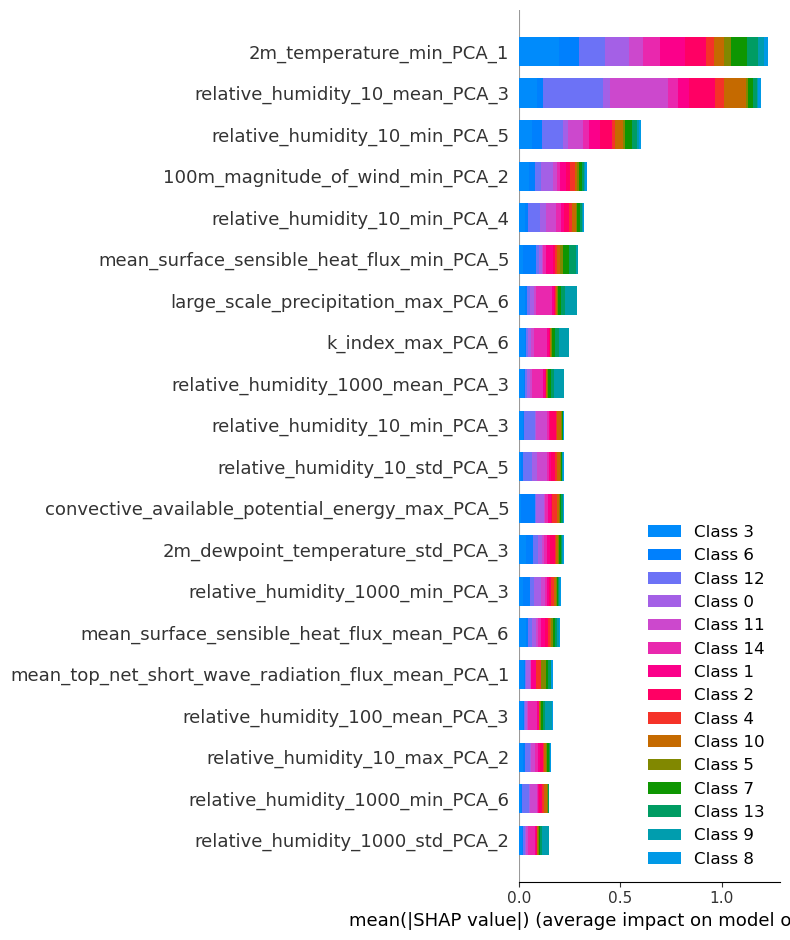

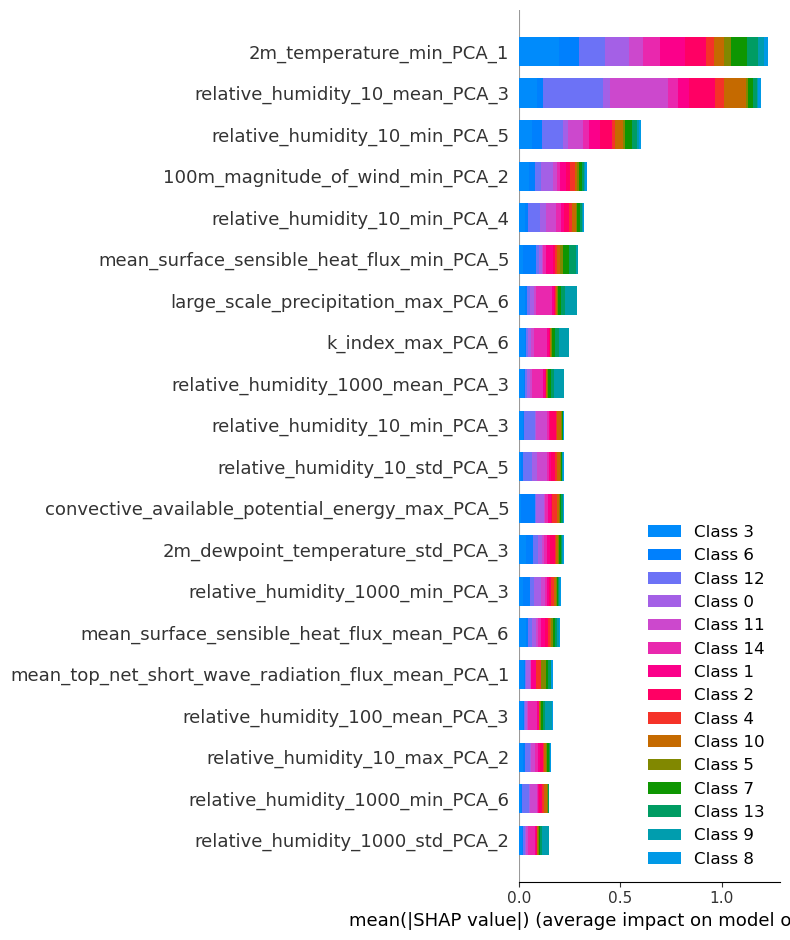

In [56]:
import shap
X_data = X_train_full_T
# Initialize the SHAP explainer for tree-based models
explainer = shap.TreeExplainer(best_model)

# Compute SHAP values
shap_values = explainer.shap_values(X_data)

# Summary plot (global feature importance)
shap.summary_plot(shap_values, X_data)

# Bar plot (average magnitude of SHAP values)
shap.summary_plot(shap_values, X_data, plot_type="bar")